In [1]:
# necessary imports

%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stat
import pandas as pd
import datetime as dt
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

# Reflect Tables into SQLAlchemy ORM

In [2]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [3]:
# reflect an existing database into a new model

Base = automap_base()

# reflect the tables

Base.prepare(engine, reflect=True)

In [4]:
# We can view all of the classes that automap found

Base.classes.keys()

['measurement', 'station']

In [5]:
# Save references to each table

Measurement = Base.classes.measurement
Station = Base.classes.station

In [6]:
# Create our session (link) from Python to the DB

session = Session(engine)

# Exploratory Climate Analysis

In [7]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

In [8]:
# Calculate the date 1 year ago from the last data point in the database

previous = dt.date(2017, 8, 23) - dt.timedelta(days=365)

In [9]:
# Perform a query to retrieve the date and precipitation scores

results = session.query(Measurement.date, Measurement.prcp).\
        filter(Measurement.date >= previous).all()

In [10]:
# Save the query results as a Pandas DataFrame and set the index to the date column

resultsDF = pd.DataFrame(results, columns=['date', 'precipitation'])
resultsDF.set_index('date', inplace=True)
resultsDF.head()

,precipitation
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


In [11]:
# Sort the dataframe by date

resultsDF.sort_values('date', inplace=True)

In [12]:
resultsDF.columns

Index(['precipitation'], dtype='object')

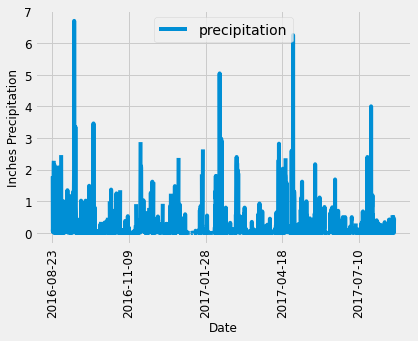

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data

resultsDF.plot(fontsize=12, rot=90)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Inches Precipitation', fontsize=12)
plt.savefig("Output/PrecipitationByDate.png", bbox_inches='tight')
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data

resultsDF.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?

stations_count = session.query(func.count(Station.station)).all()
stations_count

[(9)]

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                  group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

In [18]:
# lowest temperature recorded

low_temp = session.query(func.min(Measurement.tobs)).\
           filter(Measurement.station == 'USC00519281').all()
low_temp

[(54.0)]

In [19]:
# highest temperature recorded

high_temp = session.query(func.max(Measurement.tobs)).\
           filter(Measurement.station == 'USC00519281').all()
high_temp

[(85.0)]

In [20]:
# average temperature

avg_temp = session.query(func.avg(Measurement.tobs)).\
           filter(Measurement.station == 'USC00519281').all()
avg_temp

[(71.66378066378067)]

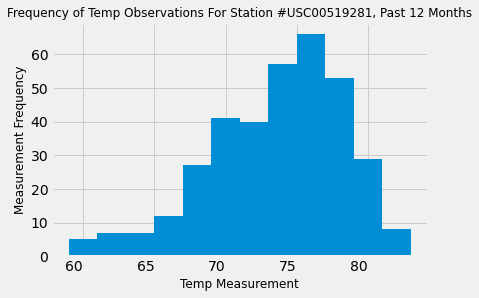

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_temp_stations = session.query(Measurement.station, func.count(Measurement.tobs)).\
                  group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()

past_year_temps = session.query(Measurement.tobs).\
                  filter(Measurement.date >= previous).\
                  filter(Measurement.station == 'USC00519281').all()

temps = []
for temp in past_year_temps:
    temps.append(temp[0])
    
fig, ax = plt.subplots()
ax.hist(temps, bins=12)
plt.xlabel('Temp Measurement', fontsize=12)
plt.ylabel('Measurement Frequency', fontsize=12)
plt.title('Frequency of Temp Observations For Station #USC00519281, Past 12 Months', fontsize=12)
plt.xticks(horizontalalignment='right')
plt.savefig("Output/FrequencyofTempObservationsHist.png", bbox_inches='tight')
plt.show()

## Bonus Challenge Assignment

In [121]:
# Temperature Analysis I from GitLab

# Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, for example, June and December?
# Identify the average temperature in June at all stations across all available years in the dataset. Do the same for December temperature.
# Use the t-test to determine whether the difference in the means, if any, is statistically significant. Will you use a paired t-test, or an unpaired t-test? Why?


June = session.query(Measurement.tobs).filter(func.strftime("%m", Measurement.date) == '06').all()
December = session.query(Measurement.tobs).filter(func.strftime("%m", Measurement.date) == '12').all()


June_avg = session.query(func.avg(Measurement.tobs)).filter(func.strftime("%m", Measurement.date) == '06').all()
Decem_avg = session.query(func.avg(Measurement.tobs)).filter(func.strftime('%m', Measurement.date) == '12').all()
print(f'June Avg: {round(June_avg[0][0], 2)}\nNumber of measurements: {len(June)}\n\nDecember Avg: {round(Decem_avg[0][0], 2)}\nNumber of measurements: {len(December)}')

June Avg: 74.94
Number of measurements: 1700

December Avg: 71.04
Number of measurements: 1517


In [122]:
# We'll use Welch's t-test, which in scipy is effected with an independent t-test set to unequal variance, because the sample
# sizes are very different. If the sample sizes were the same I would have used a paired t-test because the same stations 
# provided info, just under different conditions. Any input here on best practice would be awesome!

t, p = stat.mstats.ttest_ind(June, December, equal_var=False)

print(f'The t value is: {round(t[0], 3)}, showing that there is much more variation between the groups than within them.')
print(f'The p value is: {p}, showing that there is almost no way the difference between groups is due to chance.')

The t value is: 31.355, showing that there is much more variation between the groups than within them.
The p value is: 4.1935298359162927e-187, showing that there is almost no way the difference between groups is due to chance.


In [108]:
# There is a significant difference between the means, showing that there really is a change in weather from summer 
# to winter. However, I still consider 71F to be mild! I don't think these results ruin HI's reputation

In [22]:
# Temperature Analysis II

# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [138]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates

# 'my trip' is from 2017-10-30 to 2017-11-13, so it will be based on 2016 values

stats = calc_temps('2016-10-30', '2016-11-13')
tmin = stats[0][0]
tavg = stats[0][1]
tmax = stats[0][2]

print(f'Stats:\ntmin: {tmin}F\ntavg: {round(tavg, 2)}F\ntmax: {tmax}F')

Stats:
tmin: 63.0F
tavg: 74.3F
tmax: 79.0F


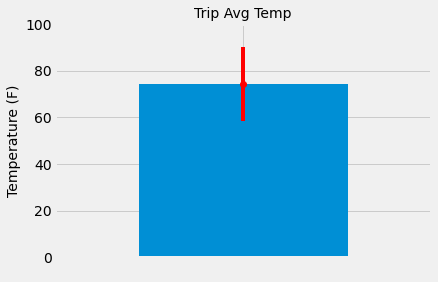

In [137]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig, ax = plt.subplots()
plt.bar(' ', tavg, width = 1)
ax.set_xlim(-0.9,0.9)
ax.set_ylim(0,100)
ax.errorbar(' ', tavg, yerr=(tmax - tmin), fmt='-o', color='red')
plt.ylabel('Temperature (F)', fontsize=14)
plt.title('Trip Avg Temp', fontsize=14)
plt.savefig("Output/TripAvgTemp.png", bbox_inches='tight')
plt.show()

In [124]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

# 'my trip' is from 2017-10-30 to 2017-11-13, so it will be based on 2016 values

start = dt.date(2016, 10, 30)
end = dt.date(2016, 11, 13)
total_rain = session.query(Measurement, Station, Station.name, Station.station, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
             filter(Measurement.station == Station.station).\
             filter(Measurement.date >= start).\
             filter(Measurement.date <= end).\
             group_by(Station.name).\
             order_by(func.sum(Measurement.prcp).desc()).all()


for stat in total_rain:
    print(f'Station Name: {stat.name}\nStation Number: {stat.station}\nStation Lat: {stat.latitude}')
    print(f'Station Lng: {stat.longitude}\nStation Elevation: {stat.elevation}\nSum of prcp: {round(stat[7], 2)}\n')
    

Station Name: MANOA LYON ARBO 785.2, HI US
Station Number: USC00516128
Station Lat: 21.3331
Station Lng: -157.8025
Station Elevation: 152.4
Sum of prcp: 3.57

Station Name: WAIHEE 837.5, HI US
Station Number: USC00519281
Station Lat: 21.45167
Station Lng: -157.84888999999998
Station Elevation: 32.9
Sum of prcp: 0.69

Station Name: KUALOA RANCH HEADQUARTERS 886.9, HI US
Station Number: USC00514830
Station Lat: 21.5213
Station Lng: -157.8374
Station Elevation: 7.0
Sum of prcp: 0.46

Station Name: KANEOHE 838.1, HI US
Station Number: USC00513117
Station Lat: 21.4234
Station Lng: -157.8015
Station Elevation: 14.6
Sum of prcp: 0.4

Station Name: WAIKIKI 717.2, HI US
Station Number: USC00519397
Station Lat: 21.2716
Station Lng: -157.8168
Station Elevation: 3.0
Sum of prcp: 0.34

Station Name: WAIMANALO EXPERIMENTAL FARM, HI US
Station Number: USC00519523
Station Lat: 21.33556
Station Lng: -157.71139
Station Elevation: 19.5
Sum of prcp: 0.31

Station Name: PEARL CITY, HI US
Station Number: US

In [26]:
# Daily Rainfall Average

# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [27]:
# calculate the daily normals for your trip
# Set the start and end date of the trip

# 'my trip' is from 2017-10-30 to 2017-11-13, so it will be based on 2016-10-30 to 2016-11-13

In [125]:
# Use the start and end date to create a range of dates
# Strip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date
# push each tuple of calculations into a list called `normals`

trip_duration = (end - start).days + 1

normals = []
trip_dates = []
for day in range(trip_duration): 
    date = start + dt.timedelta(days=day)
    trip_dates.append(date.strftime('%m-%d-%y'))
    formatted_date = date.strftime('%m-%d')
    normal_set = daily_normals(str(formatted_date))
    normals.append(normal_set)

In [126]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

tmin = []
tavg = []
tmax = []

for day in range(trip_duration):
    tmin.append(normals[day][0][0])
    tavg.append(normals[day][0][1])
    tmax.append(normals[day][0][2])
    
normals_df = pd.DataFrame()
  
normals_df['date'] = trip_dates
normals_df['tmin'] = tmin 
normals_df['tavg'] = tavg
normals_df['tmax'] = tmax

normals_df.set_index('date', inplace=True)

normals_df

,tmin,tavg,tmax
date,,,
10-30-16,64.0,74.660000,81.0
10-31-16,67.0,74.836735,80.0
11-01-16,65.0,74.862745,83.0
11-02-16,64.0,74.062500,81.0
11-03-16,66.0,74.959184,82.0
11-04-16,65.0,74.075472,82.0
11-05-16,64.0,73.557692,78.0
11-06-16,66.0,74.311111,81.0
11-07-16,63.0,73.760000,80.0


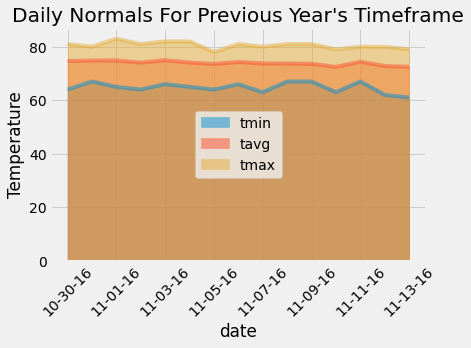

In [139]:
# Plot the daily normals as an area plot with `stacked=False`

normals_df.plot.area(stacked=False, rot=45)
plt.legend(loc='center')
plt.ylabel('Temperature')
plt.title("Daily Normals For Previous Year's Timeframe")
plt.savefig('Output/DailyNormals.png', bbox_inches='tight')
plt.show()